In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
import scipy
import pandas as pd
from scipy import stats

In [2]:
volume_cryptos = pd.read_pickle('./volume_cryptos.pkl').astype('float')
volume_cryptos.head()

,"(1, 1)","(1, 2)","(1, 3)","(1, 4)","(1, 5)","(1, 6)","(1, 7)","(1, 8)","(1, 9)","(1, 10)",...,"(3, 14)","(3, 15)","(3, 16)","(3, 17)","(3, 18)","(3, 19)","(3, 20)","(3, 21)","(3, 22)","(3, 23)"
0,15.414765,5.744616,9.840480,133.170449,231.888533,14.138344,54.186424,294.255453,30.493175,3.632668,...,152.931687,94.319238,75.450048,1447.099356,1165.970117,300.085494,700.473107,51.864564,147.663626,297.985858
1,39.561012,13.674923,6.091176,29.734829,367.952974,1.360424,8.722716,60.359270,26.208239,2.839873,...,0.000000,53.792684,302.533879,597.365108,227.328293,2080.325992,200.396057,108.703085,197.378476,0.000000
2,34.740935,6.071056,7.774974,158.906257,164.251740,2.721169,32.631296,49.861635,25.406638,20.767423,...,234.485838,203.519174,1660.249400,157.183563,250.954446,276.848736,146.669942,332.711436,100.293547,0.000000
3,77.494127,166.328320,92.752818,23.981036,8.846498,11.161393,112.987496,111.447507,16.868482,9.268062,...,142.891126,647.076503,553.665784,188.070088,124.122340,368.929888,279.159227,778.891331,17.682221,0.000000
4,31.843179,1.647833,149.395656,221.860603,17.467606,53.982262,47.311293,211.829101,9.910716,5.411363,...,375.477158,118.862287,182.785104,311.361137,144.336178,172.521523,155.210807,192.128294,51.834116,0.000000


In [3]:
volume_cryptos.shape

(1440, 83)

In [4]:
volume_days = pd.read_pickle('./volume_days.pkl').astype('float')
volume_days.head()

,BCH-USD,BTC-USD,ETH-USD,LTC-USD
0,93.083454,34.137577,340.592027,505.784326
1,80.429848,34.463230,274.984873,400.732208
2,69.460118,27.074880,302.014200,342.102581
3,52.536899,26.305374,259.083784,234.649025
4,52.004395,18.678061,198.096192,211.271475


In [5]:
volume_days.shape

(1440, 4)

In [16]:
u, sigma, v_t = np.linalg.svd(volume_cryptos, full_matrices=False, compute_uv=True)

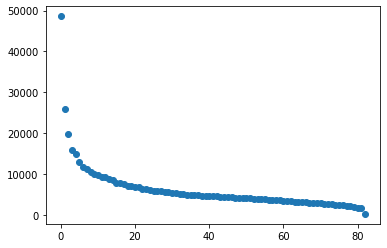

In [7]:
plt.scatter(range(len(sigma)), sigma);

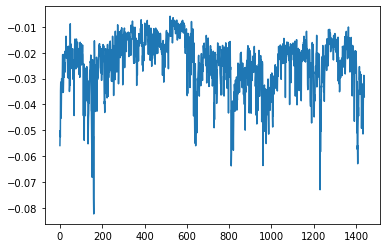

In [8]:
w = u[:, 0]
plt.plot(range(len(w)), w);

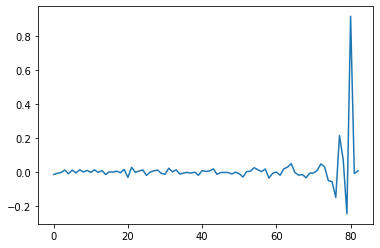

In [9]:
w = v_t[:, 0]
plt.plot(range(len(w)), w);

In [32]:
u, sigma, v_t = np.linalg.svd(volume_cryptos, full_matrices=False, compute_uv=True)

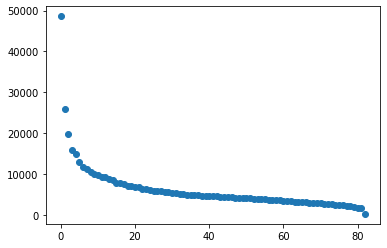

In [33]:
plt.scatter(range(len(sigma)), sigma);

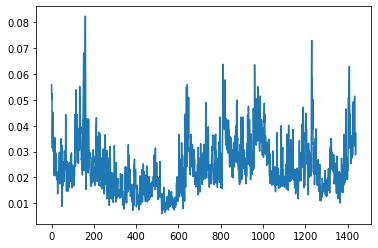

In [34]:
w = u[:, 0]
plt.plot(range(len(w)), -w);

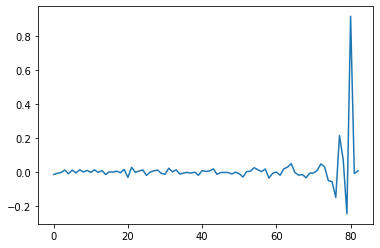

In [35]:
w = v_t[:, 0]
plt.plot(range(len(w)), w);

In [36]:
signal = -u[:, 0]
v_1 = np.concatenate((signal[:200], signal[600:]))
v_2 = signal[200:600]

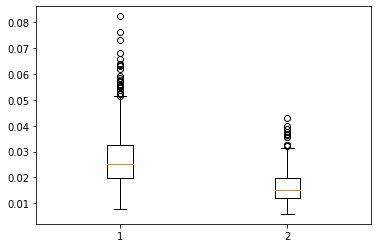

In [37]:
plt.boxplot((v_1, v_2));

In [38]:
stats.mannwhitneyu(v_1, v_2)

MannwhitneyuResult(statistic=65225.0, pvalue=4.843290943900468e-91)

In [40]:
sigma[4:] = 0
data = np.matmul(u, np.diag(sigma))
data = np.matmul(data, v_t)
np.max(np.abs(data - volume_cryptos.as_matrix()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


8588.923733265037